# Landsat Surface Reflectance <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


* **Products used:** 
[ls5_sr](https://explorer.digitalearth.africa/ls5_sr),
[ls7_sr](https://explorer.digitalearth.africa/ls7_sr),
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr),
[ls9_sr](https://explorer.digitalearth.africa/ls9_sr)

## Background

The United States Geological Survey's (USGS) [Landsat satellite program](https://www.nasa.gov/mission_pages/landsat/overview/index.html) has been capturing images of the African continent for more than 30 years. These data are highly useful for land and coastal mapping studies.

DE Africa's Landsat data is ingested from the [USGS Collection 2, Level 2](https://www.usgs.gov/land-resources/nli/landsat/landsat-collection-2?qt-science_support_page_related_con=1#qt-science_support_page_related_con) archive and forms a single, cohesive Analysis Ready Data (ARD) package, which allows you to analyse surface reflectance data as-is without the need to apply additional corrections.

**Important details:**

* Surface reflectance product
    * Native scaling range: `1 - 65,455` (`0` is `no-data`)
    * To achieve surface reflectance values, normalise values to `0 - 1` using `ds = ds * 2.75e-5 - 0.2`
    * Using `dc.load` will load data in the native scaling range `1 - 65,455`, while using `load_ard` will scale the values
* [CFMask](https://github.com/USGS-EROS/espa-cloud-masking/tree/master/cfmask) used as cloud mask
* Native pixel alignment is `centre`
* Date-range: 1984 &ndash; present
* Spatial resolution: 30 x 30 m

For a detailed description of DE Africa's Landsat archive, see the DE Africa's [Landsat surface reflectance technical specifications documentation](https://docs.digitalearthafrica.org/en/latest/data_specs/Landsat_C2_SR_specs.html).

## Description

In this notebook we will load **Landsat** data using two methods.  Firstly, we will use [dc.load()](../Beginners_guide/03_Loading_data.ipynb) to return a time series of satellite images from a single sensor. 

Secondly, we will load a time series using the [load_ard()](../Frequently_used_code/Using_load_ard.ipynb) function, which is a wrapper function around the `dc.load` module. This function will load all the images from Landsat 5,7,8 & 9, combine them, and then apply a cloud mask. The returned `xarray.Dataset` will contain analysis ready images with the cloudy and invalid pixels masked out.

Topics covered include:
1. Inspecting the Landsat products and measurements available in the datacube
2. Using the native `dc.load()` function to load in Landsat data from a single satellite
3. Using the `load_ard()` wrapper function to load in a concatenated, sorted, and cloud masked time series from Landsat 5, 7, 8 & 9.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import datacube

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Landsat_Surface_Reflectance")

## Available products and measurements

### List products

We can use datacube's `list_products` functionality to inspect DE Africa's Landsat products that are available in the datacube. The table below shows the product names that we will use to load the data, a brief description of the data, and the satellite instrument that acquired the data.

> We can search for Landsat Collection 2 Surface Reflectance data by using the search term `sr`. `sr` stands for "surface reflectance". The datacube is case-sensitive so this must be typed in lower case.

In [3]:
# List Landsat products available in DE Africa
dc_products = dc.list_products()
display_columns = ['name', 'description']
dc_products[dc_products.name.str.contains(
    'sr').fillna(
        False)][display_columns].set_index('name')

,description
name,
dem_srtm,1 second elevation model
dem_srtm_deriv,1 second elevation model derivatives
ls5_sr,USGS Landsat 5 Collection 2 Level-2 Surface Re...
ls7_sr,USGS Landsat 7 Collection 2 Level-2 Surface Re...
ls8_sr,USGS Landsat 8 Collection 2 Level-2 Surface Re...
ls9_sr,USGS Landsat 9 Collection 2 Level-2 Surface Re...


### List measurements

We can further inspect the data available for each Landsat product using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data.

In [4]:
dc_measurements = dc.list_measurements()
dc_measurements.loc['ls9_sr']

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
SR_B1,SR_B1,uint16,1,0.0,"[band_1, coastal_aerosol]",NaN
SR_B2,SR_B2,uint16,1,0.0,"[band_2, blue]",NaN
SR_B3,SR_B3,uint16,1,0.0,"[band_3, green]",NaN
SR_B4,SR_B4,uint16,1,0.0,"[band_4, red]",NaN
SR_B5,SR_B5,uint16,1,0.0,"[band_5, nir]",NaN
SR_B6,SR_B6,uint16,1,0.0,"[band_6, swir_1]",NaN
SR_B7,SR_B7,uint16,1,0.0,"[band_7, swir_2]",NaN
QA_PIXEL,QA_PIXEL,uint16,bit_index,1.0,"[pq, pixel_quality]","{'snow': {'bits': 5, 'values': {'0': 'not_high..."
QA_RADSAT,QA_RADSAT,uint16,bit_index,0.0,"[radsat, radiometric_saturation]","{'nir_saturation': {'bits': 4, 'values': {'0':..."


## Load Landsat using `dc.load()`

Now that we know what products and measurements are available for the products, we can load data from the datacube using `dc.load`.

In the example below, we will load data from Landsat 9 from Cape Town for South Africa in January 2022. We will load data from three spectral satellite bands, as well as cloud masking data (`'qa_aerosol'`). By specifying `output_crs='EPSG:6933'` and `resolution=(-30, 30)`, we request that datacube reproject our data to the African Albers coordinate reference system (CRS), with 30 x 30 m pixels. Finally, `group_by='solar_day'` ensures that overlapping images taken within seconds of each other as the satellite passes over are combined into a single time step in the data.

> Note: For a more general discussion of how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.


In [5]:
# load data
ds = dc.load(product="ls9_sr",
             measurements=['red', 'green', 'blue',
                           'qa_aerosol'],
             output_crs='EPSG:6933',
             y=(-34.31, -34.36),
             x=(18.44, 18.50),
             time=("2022-01", "2022-01"),
             resolution=(-30, 30),
             group_by="solar_day",
             )

print(ds)

<xarray.Dataset>
Dimensions:      (time: 2, y: 177, x: 194)
Coordinates:
  * time         (time) datetime64[ns] 2022-01-01T08:35:54.420393 2022-01-17T...
  * y            (y) float64 -4.126e+06 -4.126e+06 ... -4.131e+06 -4.131e+06
  * x            (x) float64 1.779e+06 1.779e+06 ... 1.785e+06 1.785e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 8995 8851 8763 8678 ... 7173 7173 7164 7127
    green        (time, y, x) uint16 9122 8918 8850 8762 ... 7594 7594 7587 7527
    blue         (time, y, x) uint16 8176 8071 8021 7965 ... 7523 7523 7539 7508
    qa_aerosol   (time, y, x) uint8 160 160 160 160 160 ... 164 164 164 164 164
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


### Plotting Landsat data

We can plot the data we loaded using the `rgb` function. By default, the function will plot data as a true colour image using the 'red', 'green', and 'blue' bands.


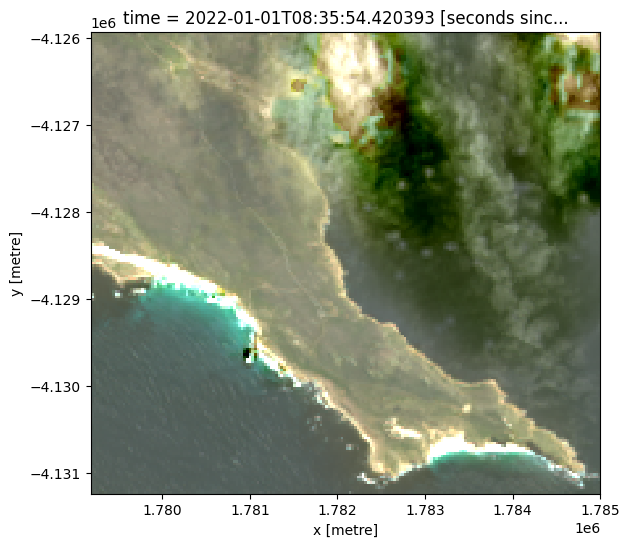

In [6]:
rgb(ds, index=0)

## Load Landsat using `load_ard`

`load_ard` applies the linear scaling and offset which converts the native `uint16` data to actual surface reflectance values. `load_ard` will additionally concatenate and sort the observations by time, and apply a cloud mask. The result is an analysis-ready dataset.

In the example below, we load Landsat 9 data for the same time and place as above. Note a cloud mask has now been applied and the data converted to decimal surface reflectance values.

This function will also load images from all the Landsat sensors if they are added to the `products` argument as a list. 

You can find more information on this function from the [Using load ard](../Frequently_used_code/Using_load_ard.ipynb) notebook.

In [7]:
ds = load_ard(dc=dc,
              products=["ls9_sr"],
              measurements=['red', 'green', 'blue'],
              output_crs='EPSG:6933',
              y=(-34.31, -34.36),
              x=(18.44, 18.50),
              time=("2022-01", "2022-01"),
              resolution=(-30, 30),
              group_by="solar_day"
             )

print(ds)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls9_sr
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 1 time steps
<xarray.Dataset>
Dimensions:      (time: 1, y: 177, x: 194)
Coordinates:
  * time         (time) datetime64[ns] 2022-01-17T08:35:52.373933
  * y            (y) float64 -4.126e+06 -4.126e+06 ... -4.131e+06 -4.131e+06
  * x            (x) float64 1.779e+06 1.779e+06 ... 1.785e+06 1.785e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 0.04766 0.04522 ... -0.00299 -0.004008
    green        (time, y, x) float32 0.04926 0.04656 ... 0.008642 0.006993
    blue         (time, y, x) float32 0.03147 0.02786 ... 0.007323 0.00647
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


Plot the cloud masked landsat data:

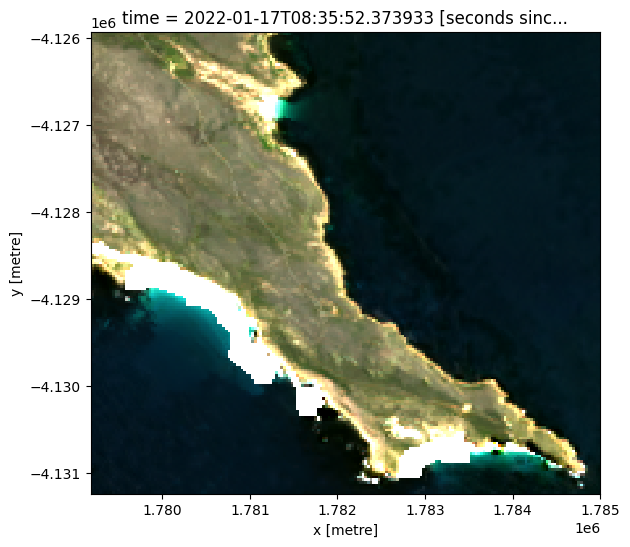

In [8]:
rgb(ds, index=0)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [9]:
print(datacube.__version__)

1.8.12


**Last Tested:**

In [10]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-03-30'